Group Members: Priti Kamat, Siddhant Bhadsavale, SriVidya Yeluripati

Question 1

In [1]:
from sklearn.datasets import make_moons
import numpy as np


train_data, _ = make_moons(n_samples=100, noise=0.1)

test_data, _ = make_moons(n_samples=100, noise=0.1)


In [2]:
class Histogram2D:
    def __init__(self, bins):
        self.bins = bins
        self.histogram = None
        self.edges = None

    def fit(self, data):
        self.histogram, self.edges = np.histogramdd(data, bins=self.bins, density=True)

    def sample(self, n_samples):
        
    
        probabilities = self.histogram.ravel()
        probabilities /= probabilities.sum()
    
    
        idx = np.random.choice(np.arange(self.histogram.size), p=probabilities, size=n_samples)
        bin_indices = np.unravel_index(idx, self.histogram.shape)
    
    
        samples = np.array([np.random.uniform(self.edges[dim][bin_indices[dim][i]], 
                                          self.edges[dim][bin_indices[dim][i] + 1])
                        for i in range(n_samples) for dim in range(len(self.edges))])
        return samples.reshape(n_samples, -1)


histogram_model = Histogram2D(bins=20)
histogram_model.fit(train_data)
histogram_samples = histogram_model.sample(100)


In [3]:
class SingleGaussian:
    def __init__(self):
        self.mean = None
        self.cov = None

    def fit(self, data):
        self.mean = np.mean(data, axis=0)
        self.cov = np.cov(data, rowvar=False)

    def sample(self, n_samples):
        return np.random.multivariate_normal(self.mean, self.cov, n_samples)


gaussian_model = SingleGaussian()
gaussian_model.fit(train_data)
gaussian_samples = gaussian_model.sample(100)


In [4]:
class GaussianMixtureModel:
    def __init__(self, n_components):
        self.n_components = n_components
        self.means = None
        self.covariances = None
        self.weights = None

    def fit(self, data, max_iter=100):
        n_samples, n_features = data.shape
        self.means = np.random.rand(self.n_components, n_features)
        self.covariances = np.array([np.eye(n_features)] * self.n_components)
        self.weights = np.ones(self.n_components) / self.n_components

        for _ in range(max_iter):
          
            responsibilities = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                
                diff = data - self.means[k]
                exponent = np.einsum('ij,ij->i', diff @ np.linalg.inv(self.covariances[k]), diff)
                coef = 1 / np.sqrt((2 * np.pi) ** n_features * np.linalg.det(self.covariances[k]))
                responsibilities[:, k] = self.weights[k] * coef * np.exp(-0.5 * exponent)
            
            responsibilities /= responsibilities.sum(axis=1, keepdims=True)

           
            Nk = responsibilities.sum(axis=0)
            for k in range(self.n_components):
                self.means[k] = (responsibilities[:, k] @ data) / Nk[k]
                diff = data - self.means[k]
                self.covariances[k] = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / Nk[k]
                self.weights[k] = Nk[k] / n_samples

    def sample(self, n_samples):
        samples = []
        for _ in range(n_samples):
            k = np.random.choice(self.n_components, p=self.weights)
            sample = np.random.multivariate_normal(self.means[k], self.covariances[k])
            samples.append(sample)
        return np.array(samples)


gmm_model = GaussianMixtureModel(n_components=2)
gmm_model.fit(train_data)
gmm_samples = gmm_model.sample(100)


In [5]:
class KDE:
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
        self.data = None

    def fit(self, data):
        self.data = data

    def sample(self, n_samples):
        samples = []
        for _ in range(n_samples):
            idx = np.random.randint(len(self.data))
            sample = self.data[idx] + np.random.normal(scale=self.bandwidth, size=self.data.shape[1])
            samples.append(sample)
        return np.array(samples)


kde_model = KDE(bandwidth=0.1)
kde_model.fit(train_data)
kde_samples = kde_model.sample(100)


In [6]:
def mmd(X, Y, kernel='rbf', bandwidth=1.0):
    XX = np.sum(kernel_func(X, X, kernel, bandwidth)) / (len(X) * len(X))
    YY = np.sum(kernel_func(Y, Y, kernel, bandwidth)) / (len(Y) * len(Y))
    XY = np.sum(kernel_func(X, Y, kernel, bandwidth)) / (len(X) * len(Y))
    return XX + YY - 2 * XY

def kernel_func(X, Y, kernel, bandwidth):
    if kernel == 'rbf':
        dists = np.sum((X[:, None] - Y[None, :]) ** 2, axis=2)
        return np.exp(-dists / (2 * bandwidth ** 2))
    elif kernel == 'imq':
        dists = np.sqrt(1 + np.sum((X[:, None] - Y[None, :]) ** 2, axis=2))
        return 1 / dists

In [7]:
mmd_histogram = mmd(test_data, histogram_samples, kernel='rbf', bandwidth=1.0)
mmd_gaussian = mmd(test_data, gaussian_samples, kernel='rbf', bandwidth=1.0)
mmd_gmm = mmd(test_data, gmm_samples, kernel='rbf', bandwidth=1.0)
mmd_kde = mmd(test_data, kde_samples, kernel='rbf', bandwidth=1.0)

print("MMD with Histogram Model:", mmd_histogram)
print("MMD with Single Gaussian:", mmd_gaussian)
print("MMD with Gaussian Mixture Model:", mmd_gmm)
print("MMD with KDE Model:", mmd_kde)


MMD with Histogram Model: 0.002196486180272128
MMD with Single Gaussian: 0.0046039371205461865
MMD with Gaussian Mixture Model: 0.007913657743876534
MMD with KDE Model: 0.0061270101608355


MMD with Histogram Model: 0.005494101969751752
MMD with Histogram Model: 0.002316252249174422
MMD with Histogram Model: 0.0013747715101921631
MMD with Histogram Model: 0.00876795737551661
MMD with Histogram Model: 0.010315707075891911
MMD with Histogram Model: 0.003967123524281524
MMD with Histogram Model: 0.002868859341540242
MMD with Histogram Model: 0.0060061962964163
MMD with Histogram Model: 0.0032625726656543286
MMD with Histogram Model: 0.0024923792874940176
MMD with Histogram Model: 0.0052840763453461115
MMD with Histogram Model: 0.001548959655262916


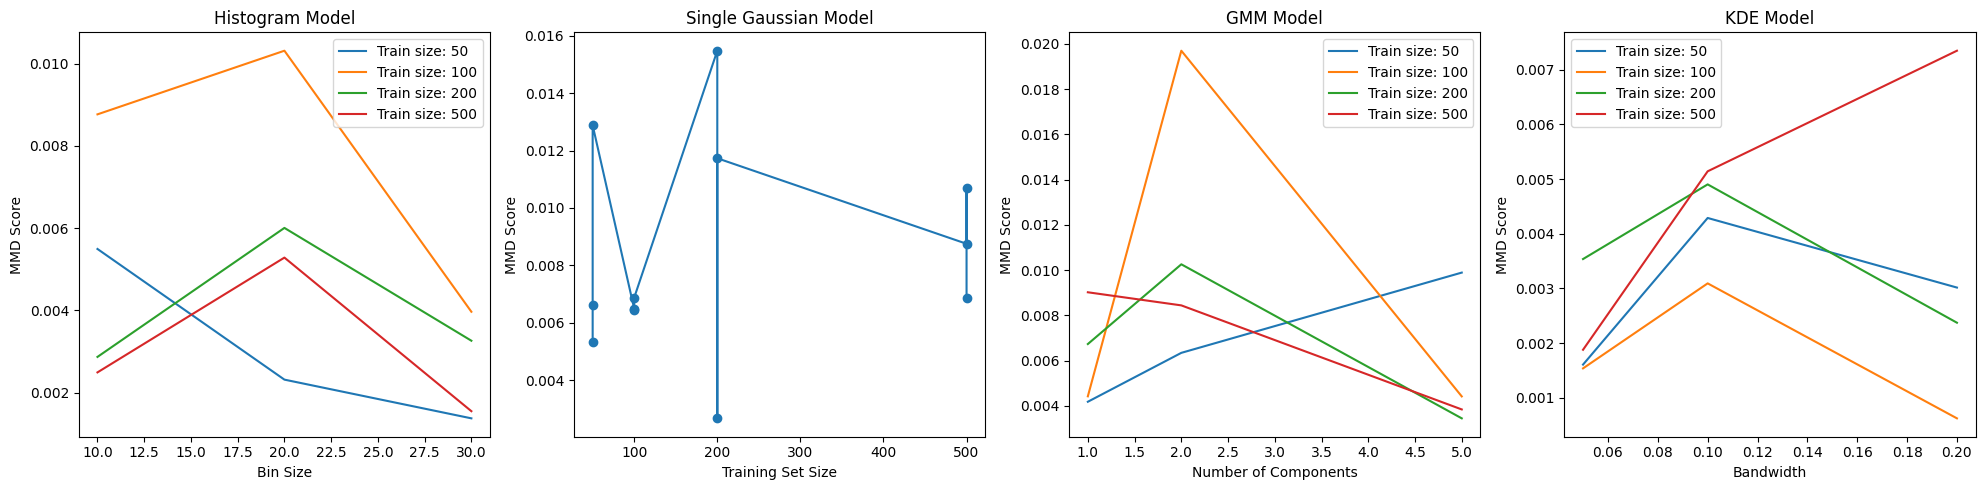

In [8]:
import matplotlib.pyplot as plt

# Function to evaluate model accuracy (MMD) with varying hyperparameters and training set sizes
def evaluate_models(train_sizes, bin_sizes, gmm_components, kde_bandwidths, test_data):
    results = {
        'Histogram': [],
        'GMM': [],
        'KDE': [],
        'Single Gaussian': [],
        
    }
    
    for size in train_sizes:
        train_data, _ = make_moons(n_samples=size, noise=0.1)
        
       
        for bins in bin_sizes:
            histogram_model = Histogram2D(bins=bins)
            histogram_model.fit(train_data)
            histogram_samples = histogram_model.sample(len(test_data))
            mmd_score = mmd(test_data, histogram_samples, kernel='rbf', bandwidth=1.0)
            print("MMD with Histogram Model:",mmd_score)
            results['Histogram'].append((size, bins, mmd_score))
            
            single_gaussian_model = SingleGaussian()
            single_gaussian_model.fit(train_data)
            single_gaussian_samples = single_gaussian_model.sample(len(test_data))
            mmd_score = mmd(test_data, single_gaussian_samples, kernel='rbf', bandwidth=1.0)
            results['Single Gaussian'].append((size, None, mmd_score))
        
        
        for components in gmm_components:
            gmm_model = GaussianMixtureModel(n_components=components)
            gmm_model.fit(train_data)
            gmm_samples = gmm_model.sample(len(test_data))
            mmd_score = mmd(test_data, gmm_samples, kernel='rbf', bandwidth=1.0)
            results['GMM'].append((size, components, mmd_score))
        
        
        for bandwidth in kde_bandwidths:
            kde_model = KDE(bandwidth=bandwidth)
            kde_model.fit(train_data)
            kde_samples = kde_model.sample(len(test_data))
            mmd_score = mmd(test_data, kde_samples, kernel='rbf', bandwidth=1.0)
            results['KDE'].append((size, bandwidth, mmd_score))
    
    return results

# Parameters for evaluation
train_sizes = [50, 100, 200, 500]
bin_sizes = [10, 20, 30]
gmm_components = [1, 2, 5]
kde_bandwidths = [0.05, 0.1, 0.2]


results = evaluate_models(train_sizes, bin_sizes, gmm_components, kde_bandwidths, test_data)


def plot_results(results):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Plot for Histogram Model
    ax = axes[0]
    for size in train_sizes:
        sizes = [res[1] for res in results['Histogram'] if res[0] == size]
        scores = [res[2] for res in results['Histogram'] if res[0] == size]
        ax.plot(sizes, scores, label=f'Train size: {size}')
    ax.set_xlabel('Bin Size')
    ax.set_ylabel('MMD Score')
    ax.set_title('Histogram Model')
    ax.legend()
    
    # Plot for Single Gaussian Model
    ax = axes[1]
    sizes = [res[0] for res in results['Single Gaussian']]
    scores = [res[2] for res in results['Single Gaussian']]
    ax.plot(sizes, scores, marker='o')
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('MMD Score')
    ax.set_title('Single Gaussian Model')
    
    # Plot for GMM Model
    ax = axes[2]
    for size in train_sizes:
        components = [res[1] for res in results['GMM'] if res[0] == size]
        scores = [res[2] for res in results['GMM'] if res[0] == size]
        ax.plot(components, scores, label=f'Train size: {size}')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('MMD Score')
    ax.set_title('GMM Model')
    ax.legend()
    
    # Plot for KDE Model
    ax = axes[3]
    for size in train_sizes:
        bandwidths = [res[1] for res in results['KDE'] if res[0] == size]
        scores = [res[2] for res in results['KDE'] if res[0] == size]
        ax.plot(bandwidths, scores, label=f'Train size: {size}')
    ax.set_xlabel('Bandwidth')
    ax.set_ylabel('MMD Score')
    ax.set_title('KDE Model')
    ax.legend()
    
    plt.tight_layout()
    plt.show()


plot_results(results)


For a number of representative models (both good and bad ones), create two 2D plots that (i)visualize the numerical values of the learned density, and (ii) visualize a generated dataset from
the model.

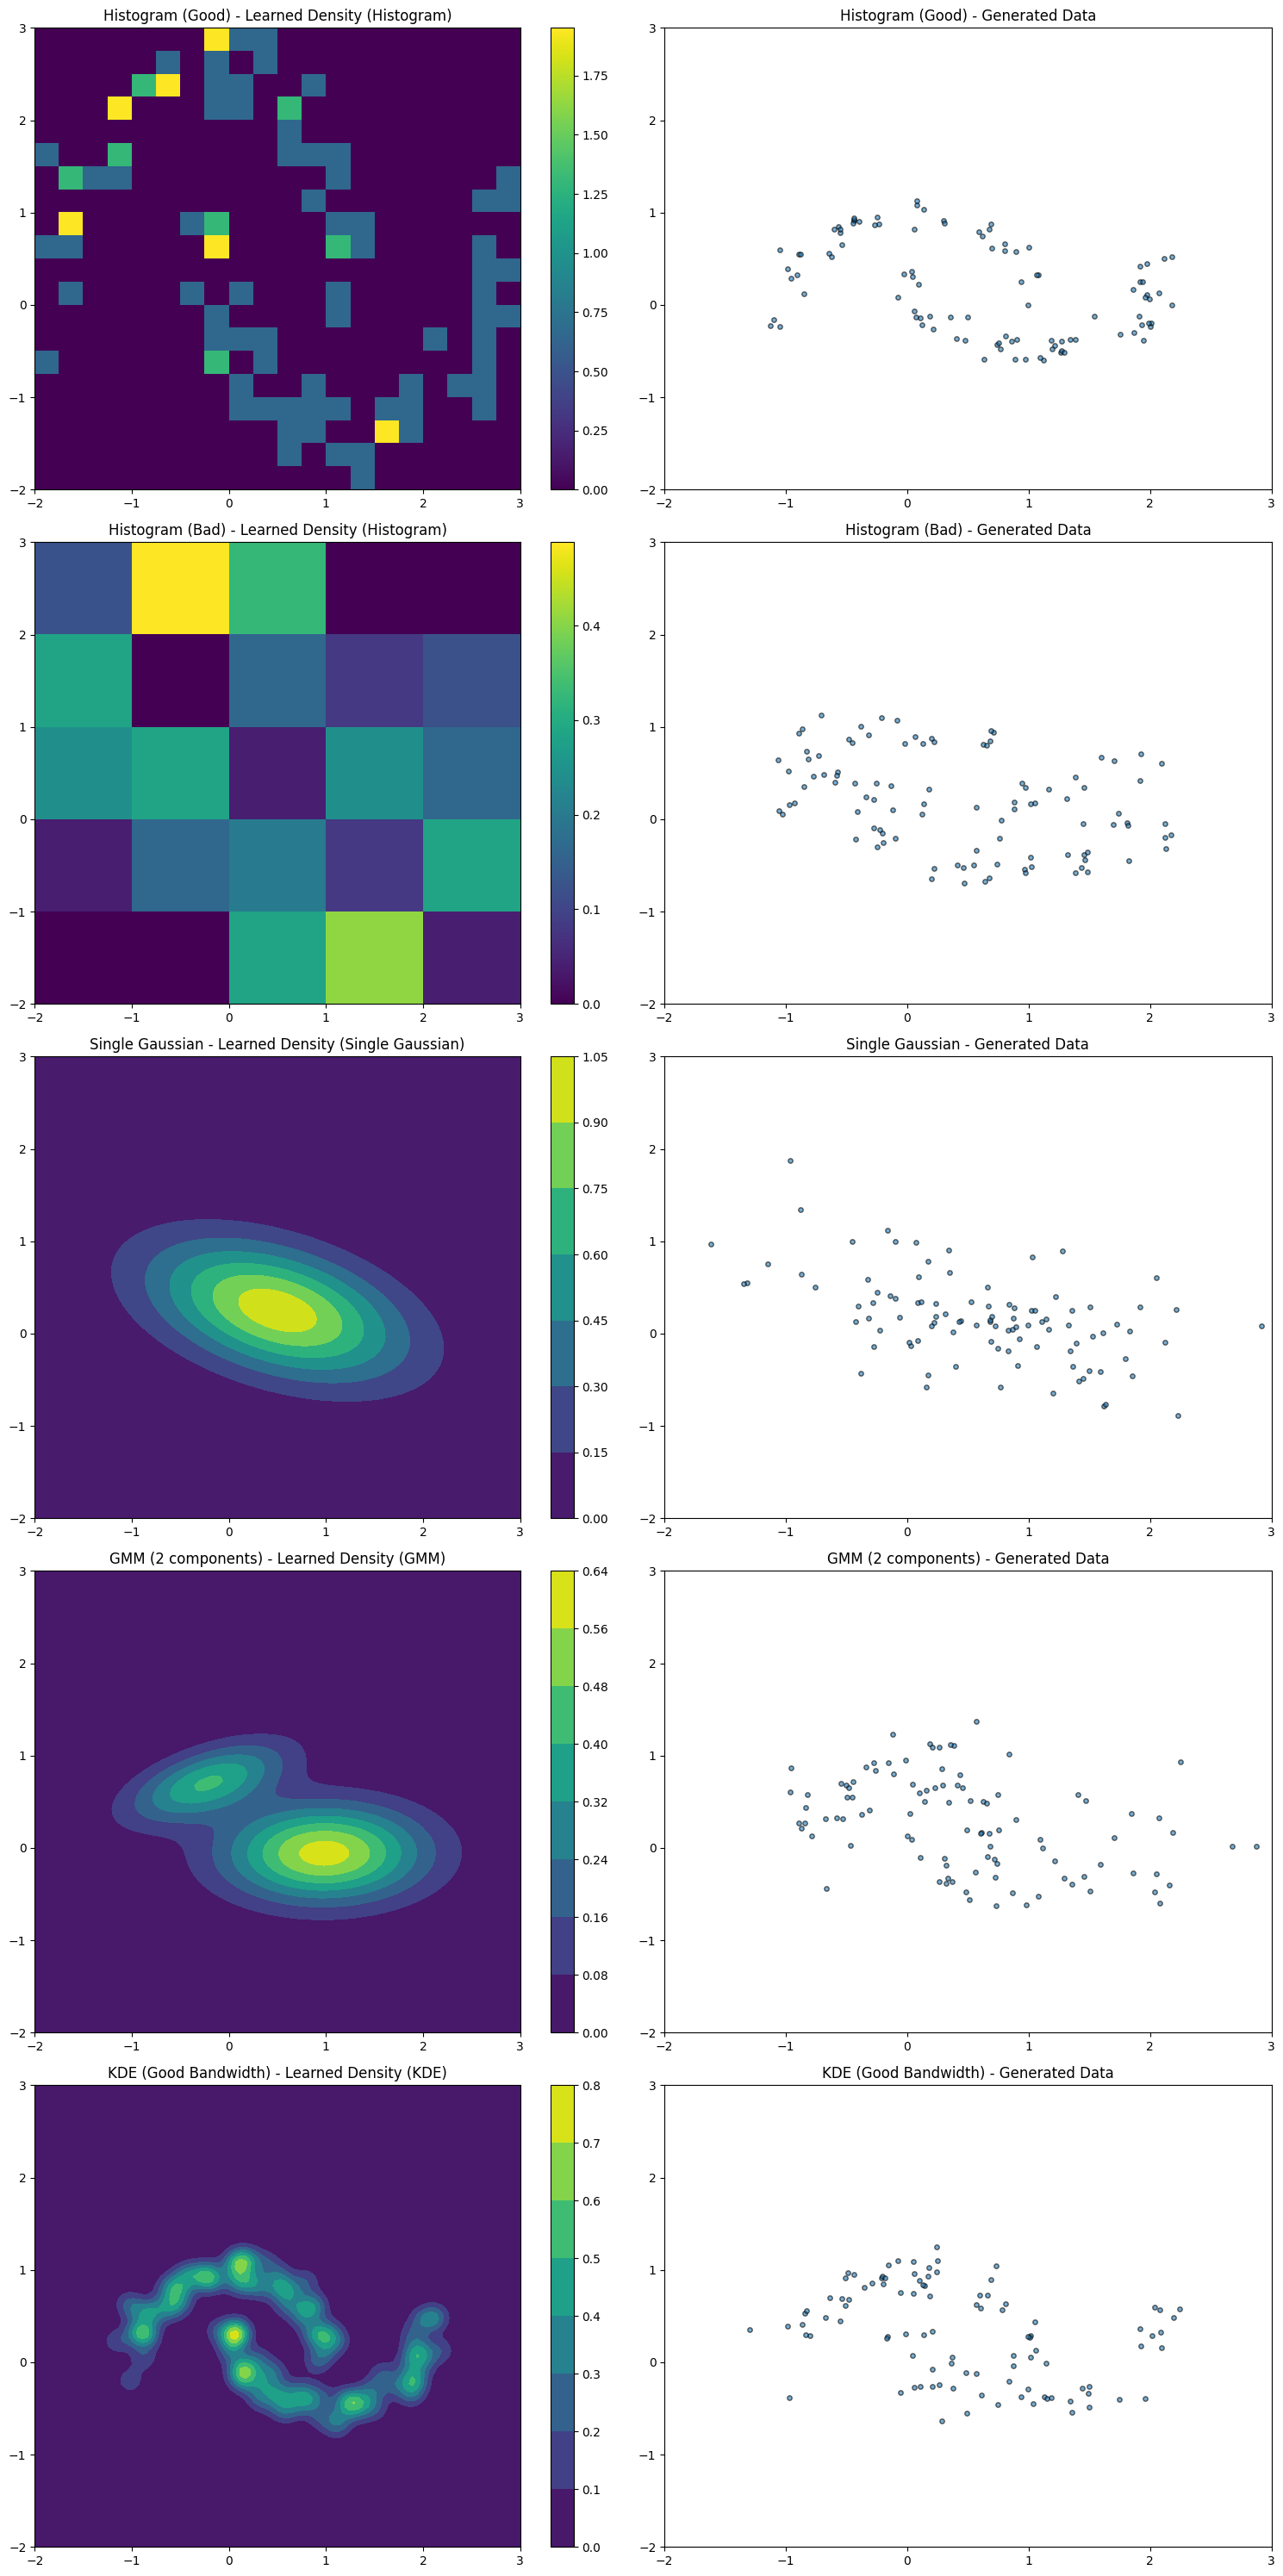

In [9]:
import matplotlib.pyplot as plt
import numpy as np


x_grid = np.linspace(-2, 3, 100)
y_grid = np.linspace(-2, 3, 100)
X, Y = np.meshgrid(x_grid, y_grid)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

def plot_model_visualizations(models, model_names, test_data):
    plt.figure(figsize=(15, len(models) * 6))
    
    for i, (model, name) in enumerate(zip(models, model_names)):
        # Learned density plot (i)
        if isinstance(model, Histogram2D):
            model.fit(test_data) 
            histogram_density, edges = np.histogramdd(test_data, bins=model.bins, density=True)
            histogram_density = histogram_density.T 
            
            plt.subplot(len(models), 2, 2 * i + 1)
            plt.imshow(histogram_density, extent=(x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]), origin='lower', aspect='auto')
            plt.colorbar()
            plt.title(f"{name} - Learned Density (Histogram)")
        
        elif isinstance(model, SingleGaussian):
            model.fit(test_data)  
            density_values = np.exp(-0.5 * np.sum(((grid_points - model.mean) @ np.linalg.inv(model.cov)) * (grid_points - model.mean), axis=1))
            density_values = density_values.reshape(X.shape)
            
            plt.subplot(len(models), 2, 2 * i + 1)
            plt.contourf(X, Y, density_values, cmap="viridis")
            plt.colorbar()
            plt.title(f"{name} - Learned Density (Single Gaussian)")
        
        elif isinstance(model, GaussianMixtureModel):
            model.fit(test_data)  
            density_values = np.zeros(len(grid_points))
            for k in range(model.n_components):
                mvn_density = np.exp(-0.5 * np.sum(((grid_points - model.means[k]) @ np.linalg.inv(model.covariances[k])) * (grid_points - model.means[k]), axis=1))
                density_values += model.weights[k] * mvn_density
            density_values = density_values.reshape(X.shape)
            
            plt.subplot(len(models), 2, 2 * i + 1)
            plt.contourf(X, Y, density_values, cmap="viridis")
            plt.colorbar()
            plt.title(f"{name} - Learned Density (GMM)")
        
        elif isinstance(model, KDE):
            model.fit(test_data)  
            density_values = np.zeros(len(grid_points))
            for data_point in model.data:
                kernel_density = np.exp(-np.sum((grid_points - data_point) ** 2, axis=1) / (2 * model.bandwidth ** 2))
                density_values += kernel_density
            density_values /= len(model.data) * (2 * np.pi * model.bandwidth ** 2)
            density_values = density_values.reshape(X.shape)
            
            plt.subplot(len(models), 2, 2 * i + 1)
            plt.contourf(X, Y, density_values, cmap="viridis")
            plt.colorbar()
            plt.title(f"{name} - Learned Density (KDE)")

        # Generated samples plot (ii)
        samples = model.sample(len(test_data))
        
        plt.subplot(len(models), 2, 2 * i + 2)
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, edgecolor='k', s=15)
        plt.xlim(-2, 3)
        plt.ylim(-2, 3)
        plt.title(f"{name} - Generated Data")
    
    plt.tight_layout()
    plt.show()


models = [
    Histogram2D(bins=20),  # Good histogram model
    Histogram2D(bins=5),   # Bad histogram model
    SingleGaussian(),      # Single Gaussian model
    GaussianMixtureModel(n_components=2),  # Good GMM
    KDE(bandwidth=0.1)     # Good KDE model
]

model_names = [
    "Histogram (Good)",
    "Histogram (Bad)",
    "Single Gaussian",
    "GMM (2 components)",
    "KDE (Good Bandwidth)"
]


plot_model_visualizations(models, model_names, test_data)


Comment on model strengths and weaknesses
1. Histogram (Good)
    Strengths: Effectively captures data structure with clear highdensity regions when bin size is wellchosen.
    Weaknesses: Limited by bin size; struggles with complex, smooth distributions.

2. Histogram (Bad)
    Strengths: Simple and easy to interpret.
    Weaknesses: Too few bins result in blocky, inaccurate density representation, missing intricate data patterns.

3. Single Gaussian
    Strengths: Suitable for unimodal, Gaussianlike data; efficient and straightforward.
    Weaknesses: Can’t capture multimodal or complex distributions, leading to oversimplified, centralized density.

4. Gaussian Mixture Model (GMM) with 2 Components
    Strengths: Models bimodal or clustered data better than a single Gaussian.
    Weaknesses: Limited by the specified component count; may underfit with more clusters or complex shapes.

5. Kernel Density Estimation (KDE) with Good Bandwidth
    Strengths: Highly flexible; accurately models complex density patterns with proper bandwidth.
    Weaknesses: Computationally intensive; sensitive to bandwidth choice, impacting detail and noise sensitivity.

Bonus: Add some representation of the model solution to your plots (e.g. the grid of the histogram, some selected mixture components of
the GMM).

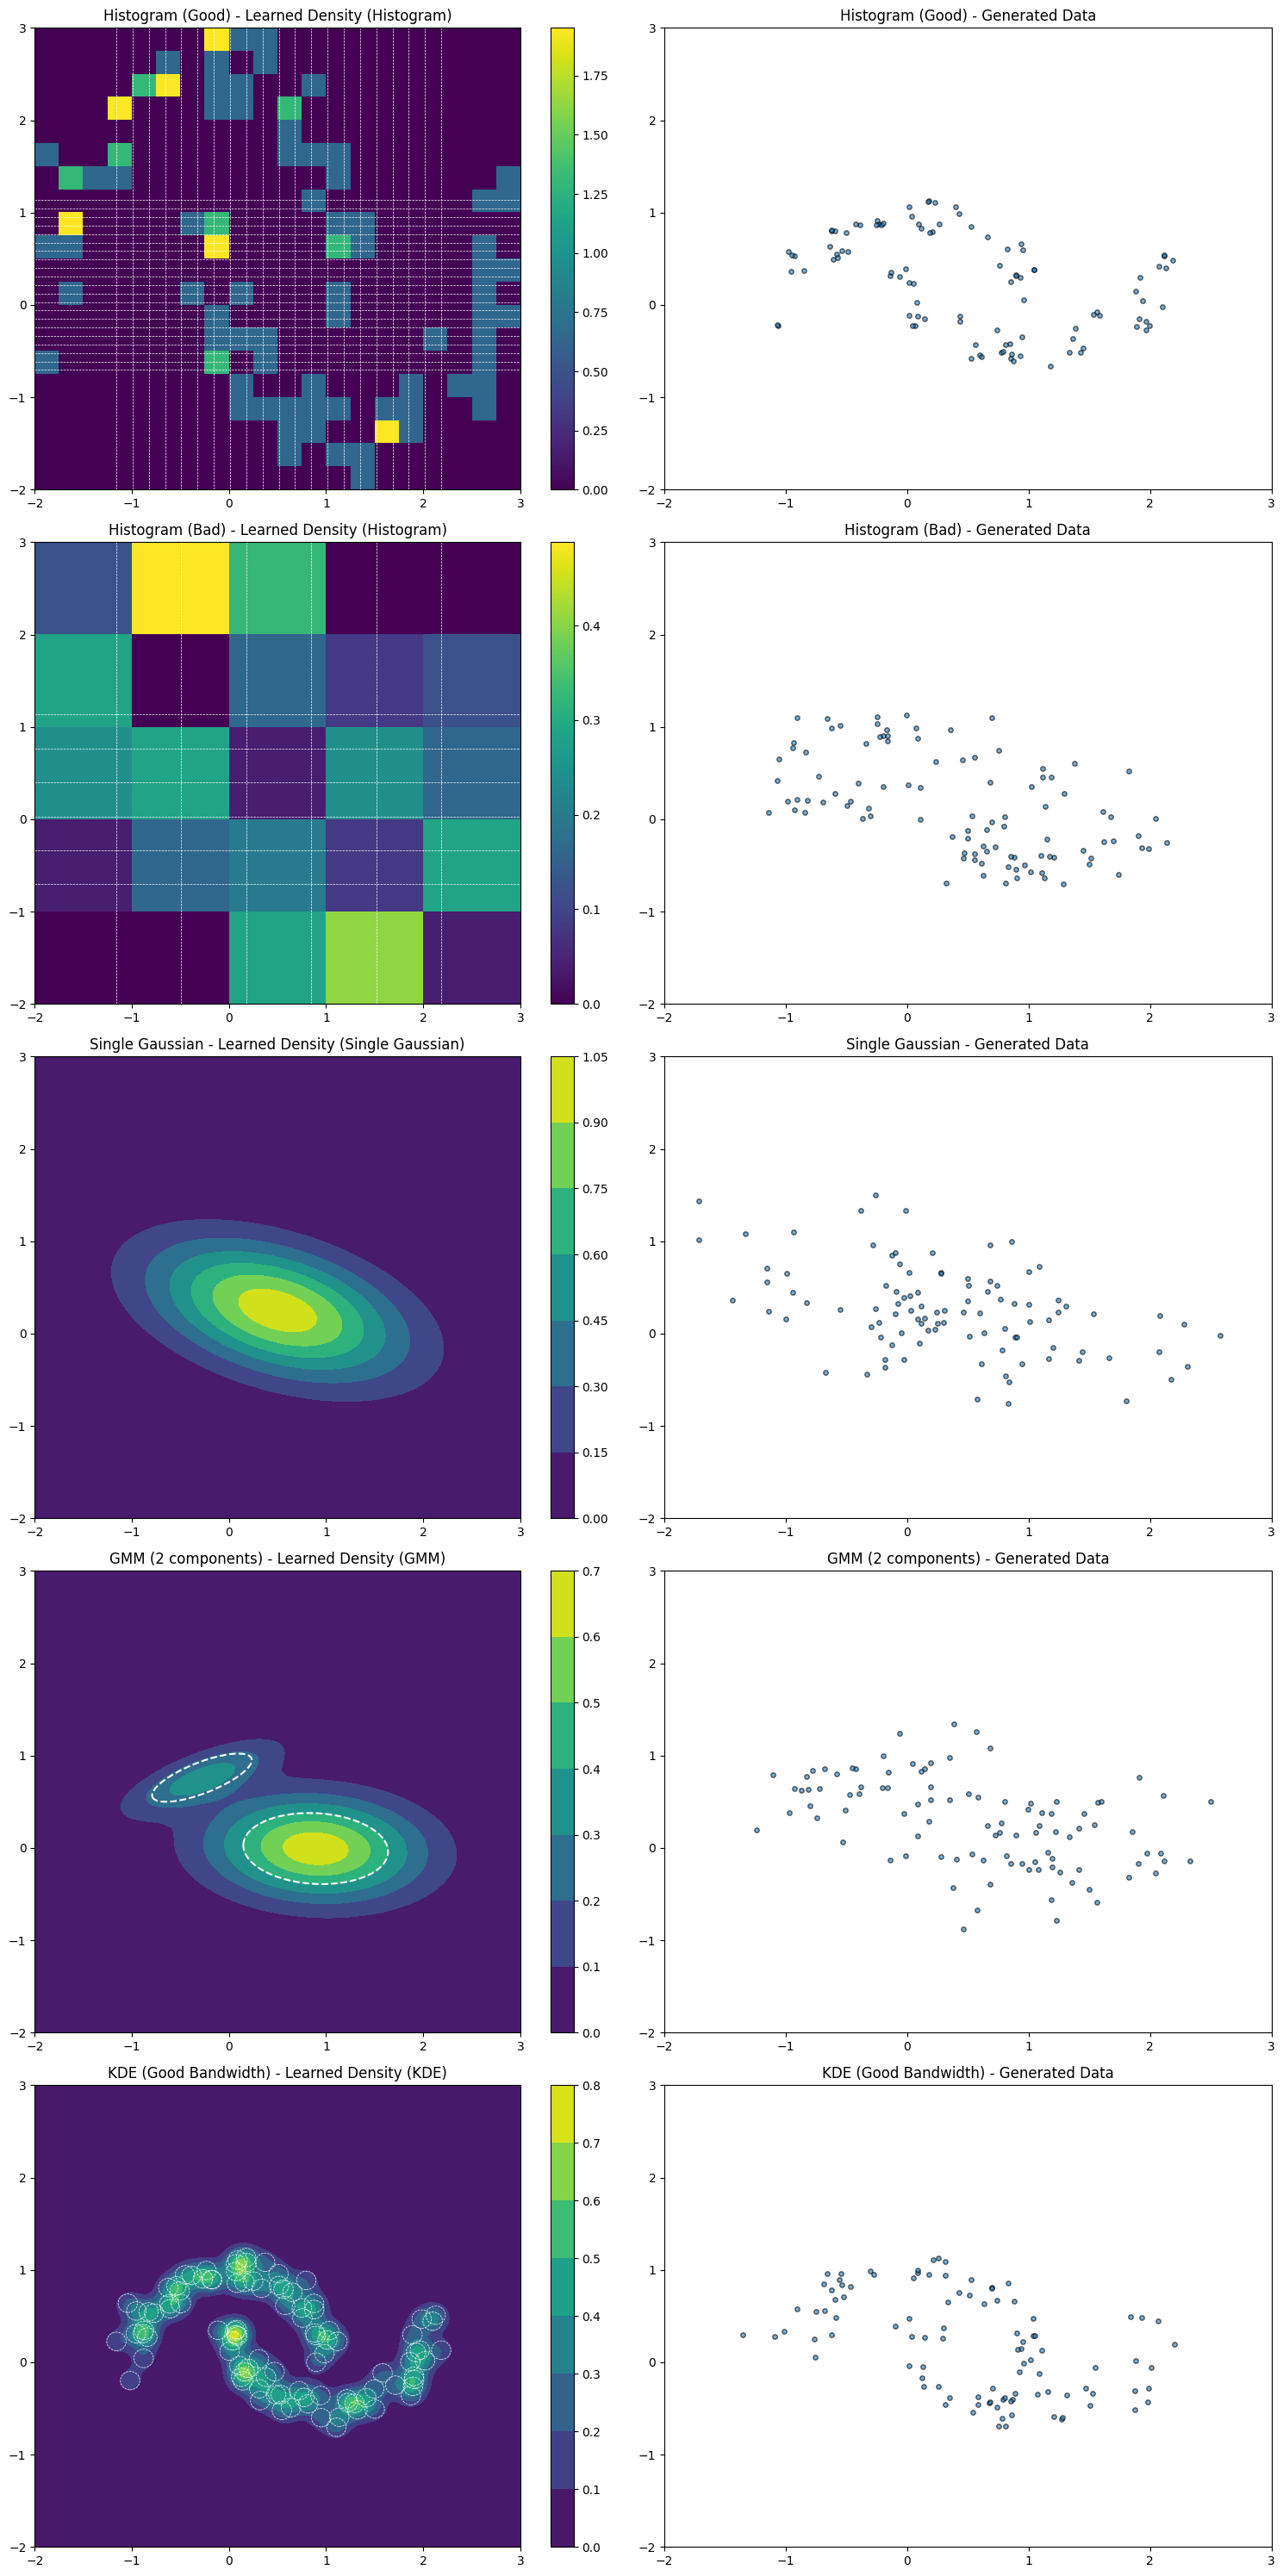

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse


x_grid = np.linspace(-2, 3, 100)
y_grid = np.linspace(-2, 3, 100)
X, Y = np.meshgrid(x_grid, y_grid)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T


def plot_model_visualizations(models, model_names, test_data):
    plt.figure(figsize=(15, len(models) * 6))
    
    for i, (model, name) in enumerate(zip(models, model_names)):
        # Learned density plot (i)
        if isinstance(model, Histogram2D):
            model.fit(test_data)  
            histogram_density, edges = np.histogramdd(test_data, bins=model.bins, density=True)
            histogram_density = histogram_density.T  
            
            plt.subplot(len(models), 2, 2 * i + 1)
            plt.imshow(histogram_density, extent=(x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]), origin='lower', aspect='auto')
            plt.colorbar()
            plt.title(f"{name} - Learned Density (Histogram)")
            
            
            for edge_x in edges[0]:
                plt.axvline(edge_x, color='white', linestyle='--', linewidth=0.5)
            for edge_y in edges[1]:
                plt.axhline(edge_y, color='white', linestyle='--', linewidth=0.5)
        
        elif isinstance(model, SingleGaussian):
            model.fit(test_data) 
            density_values = np.exp(-0.5 * np.sum(((grid_points - model.mean) @ np.linalg.inv(model.cov)) * (grid_points - model.mean), axis=1))
            density_values = density_values.reshape(X.shape)
            
            plt.subplot(len(models), 2, 2 * i + 1)
            plt.contourf(X, Y, density_values, cmap="viridis")
            plt.colorbar()
            plt.title(f"{name} - Learned Density (Single Gaussian)")
        
        elif isinstance(model, GaussianMixtureModel):
            model.fit(test_data) 
            density_values = np.zeros(len(grid_points))
            for k in range(model.n_components):
                mvn_density = np.exp(-0.5 * np.sum(((grid_points - model.means[k]) @ np.linalg.inv(model.covariances[k])) * (grid_points - model.means[k]), axis=1))
                density_values += model.weights[k] * mvn_density
            density_values = density_values.reshape(X.shape)
            
            plt.subplot(len(models), 2, 2 * i + 1)
            plt.contourf(X, Y, density_values, cmap="viridis")
            plt.colorbar()
            plt.title(f"{name} - Learned Density (GMM)")
            
           
            for k in range(model.n_components):
                mean = model.means[k]
                cov = model.covariances[k]
                eigenvalues, eigenvectors = np.linalg.eigh(cov)
                angle = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
                width, height = 2 * np.sqrt(eigenvalues)
                ellipse = Ellipse(xy=mean, width=width, height=height, angle=np.degrees(angle), edgecolor='white', fc='None', lw=1.5, linestyle='--')
                plt.gca().add_patch(ellipse)
        
        elif isinstance(model, KDE):
            model.fit(test_data)  
            density_values = np.zeros(len(grid_points))
            for data_point in model.data:
                kernel_density = np.exp(-np.sum((grid_points - data_point) ** 2, axis=1) / (2 * model.bandwidth ** 2))
                density_values += kernel_density
            density_values /= len(model.data) * (2 * np.pi * model.bandwidth ** 2)
            density_values = density_values.reshape(X.shape)
            
            plt.subplot(len(models), 2, 2 * i + 1)
            plt.contourf(X, Y, density_values, cmap="viridis")
            plt.colorbar()
            plt.title(f"{name} - Learned Density (KDE)")
            
            
            for data_point in model.data:
                circle = plt.Circle(data_point, model.bandwidth, color='white', fill=False, linestyle='--', linewidth=0.5)
                plt.gca().add_patch(circle)

        # Generated samples plot (ii)
        samples = model.sample(len(test_data))
        
        plt.subplot(len(models), 2, 2 * i + 2)
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, edgecolor='k', s=15)
        plt.xlim(-2, 3)
        plt.ylim(-2, 3)
        plt.title(f"{name} - Generated Data")
    
    plt.tight_layout()
    plt.show()


models = [
    Histogram2D(bins=20),  # Good histogram model
    Histogram2D(bins=5),   # Bad histogram model
    SingleGaussian(),      # Single Gaussian model
    GaussianMixtureModel(n_components=2),  # Good GMM
    KDE(bandwidth=0.1)     # Good KDE model
]

model_names = [
    "Histogram (Good)",
    "Histogram (Bad)",
    "Single Gaussian",
    "GMM (2 components)",
    "KDE (Good Bandwidth)"
]

plot_model_visualizations(models, model_names, test_data)


### Question 2

In [11]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from quantile_forest import RandomForestQuantileRegressor


density_forest = RandomForestQuantileRegressor(n_estimators=100, max_depth=10, random_state=42)
density_forest.fit(X_train, y_train)

def sample_density_forest(model, n_samples):
    quantiles_low = np.percentile(X_train, 10, axis=0)  
    quantiles_high = np.percentile(X_train, 90, axis=0)
    
    samples = []
    for _ in range(n_samples):
        sample = []
        for feature in range(X_train.shape[1]):
            value = np.random.uniform(quantiles_low[feature], quantiles_high[feature])
            sample.append(value)
        samples.append(sample)
    return np.array(samples)


In [14]:
import numpy as np

mean = np.mean(X_train, axis=0)
cov = np.cov(X_train, rowvar=False)

def generate_gaussian_samples(n_samples):
    return np.random.multivariate_normal(mean, cov, n_samples)


In [15]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10, random_state=42)
gmm.fit(X_train)  

def sample_gmm(model, n_samples):
    samples = model.sample(n_samples)[0]
    return samples


In [16]:
from sklearn.neighbors import KernelDensity


kde = KernelDensity(bandwidth=1.0, algorithm='kd_tree')
kde.fit(X_train)  

def sample_kde(model, n_samples):
    samples = model.sample(n_samples)
    return samples

In [17]:
def mmd(X, Y, kernel='rbf', bandwidth=1.0):
    XX = np.sum(kernel_func(X, X, kernel, bandwidth)) / (len(X) * len(X))
    YY = np.sum(kernel_func(Y, Y, kernel, bandwidth)) / (len(Y) * len(Y))
    XY = np.sum(kernel_func(X, Y, kernel, bandwidth)) / (len(X) * len(Y))
    return XX + YY - 2 * XY

def kernel_func(X, Y, kernel, bandwidth):
    if kernel == 'rbf':
        dists = np.sum((X[:, None] - Y[None, :]) ** 2, axis=2)
        return np.exp(-dists / (2 * bandwidth ** 2))
    elif kernel == 'imq':
        dists = np.sqrt(1 + np.sum((X[:, None] - Y[None, :]) ** 2, axis=2))
        return 1 / dists

density_forest_samples = sample_density_forest(density_forest, 100)
mmd_score_density_forest = mmd(X_test, density_forest_samples, kernel='rbf', bandwidth=1.0)
print("MMD Score for Density Forest:", mmd_score_density_forest)
single_gaussian_samples = generate_gaussian_samples(100)
mmd_score_single_gaussian = mmd(X_test, single_gaussian_samples, kernel='rbf', bandwidth=1.0)
print("MMD Score for Single Gaussian:", mmd_score_single_gaussian)
gmm_samples = sample_gmm(gmm, 100)
mmd_score = mmd(X_test, gmm_samples, kernel='rbf', bandwidth=1.0)
print("MMD Score for GMM:", mmd_score)
kde_samples = sample_kde(kde, 100)
mmd_score_kde = mmd(X_test, kde_samples, kernel='rbf', bandwidth=1.0)
print("MMD Score for KDE:", mmd_score_kde)

MMD Score for Density Forest: 0.012777777777777779
MMD Score for Single Gaussian: 0.012777777777777779
MMD Score for GMM: 0.012777777777777779
MMD Score for KDE: 0.012777777777777779


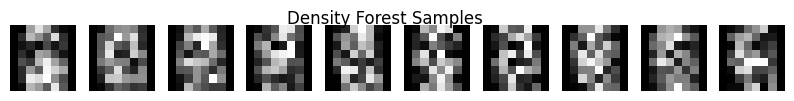

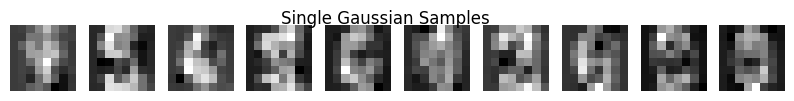

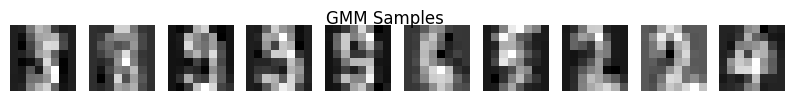

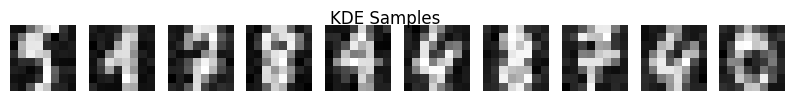

In [18]:
import matplotlib.pyplot as plt

def visualize_samples(samples, title):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    fig.suptitle(title)
    for i, ax in enumerate(axes):
        sample = samples[i]
        if sample.size != 64:
            print(f"Warning: Sample size is {sample.size}, expected 64. Skipping this sample.")
            ax.axis('off')
            continue
        ax.imshow(sample.reshape(8, 8), cmap='gray')
        ax.axis('off')
    plt.show()

visualize_samples(sample_density_forest(density_forest, 10), 'Density Forest Samples')
visualize_samples(generate_gaussian_samples(10), 'Single Gaussian Samples')
visualize_samples(sample_gmm(gmm, 10), 'GMM Samples')
visualize_samples(sample_kde(kde, 10), 'KDE Samples')


In addition, train a sklearn.ensemble.RandomForestClassifier on the original dataset to distinguish the 10 digit classes. Use this classier to check for the models which create recognisable output if the
10 digits are generated in equal proportions.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)  

def classify_samples(model_samples, model_name):
    predicted_labels = rf_classifier.predict(model_samples)
    print(f"Generated samples from {model_name} classified as digits: {np.bincount(predicted_labels)}")

classify_samples(sample_density_forest(density_forest, 100), "Density Forest")
classify_samples(generate_gaussian_samples(100), "Single Gaussian")
classify_samples(sample_gmm(gmm, 100), "GMM")
classify_samples(sample_kde(kde, 100), "KDE")

Generated samples from Density Forest classified as digits: [15  1  8  6  9  4  1  2 39 15]
Generated samples from Single Gaussian classified as digits: [10  3 13  5 14  9 12  9 16  9]
Generated samples from GMM classified as digits: [ 6  8 16 12  9  9  8  9 12 11]
Generated samples from KDE classified as digits: [12 12  7 10  9  7 12  8 14  9]
